## To do

- prefer to find better term than "intermediate", as clearly gamb_colu rather than arab. 
- better colour than grey
- tidy up offsets based on new text_va logic

In [70]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import cartopy; print('cartopy', cartopy.__version__)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np
import seaborn as sns
import gcsfs
from pathlib import Path
import yaml
import dask.array as da
from ag3 import release_data
v3_release = release_data()
#cartopy text scale issues
sns.set_context('paper', font_scale=.9)

cartopy 0.17.0


### setup data

In [71]:
#samplesets
samplesets = v3_release.all_wild_sample_sets

In [72]:
samplesets

['AG1000G-AO',
 'AG1000G-BF-A',
 'AG1000G-BF-B',
 'AG1000G-BF-C',
 'AG1000G-CD',
 'AG1000G-CF',
 'AG1000G-CI',
 'AG1000G-CM-A',
 'AG1000G-CM-B',
 'AG1000G-CM-C',
 'AG1000G-FR',
 'AG1000G-GA-A',
 'AG1000G-GH',
 'AG1000G-GM-A',
 'AG1000G-GM-B',
 'AG1000G-GM-C',
 'AG1000G-GN-A',
 'AG1000G-GN-B',
 'AG1000G-GQ',
 'AG1000G-GW',
 'AG1000G-KE',
 'AG1000G-ML-A',
 'AG1000G-ML-B',
 'AG1000G-MW',
 'AG1000G-MZ',
 'AG1000G-TZ',
 'AG1000G-UG']

In [73]:
all_meta = v3_release.load_sample_set_metadata(samplesets, True)
all_meta.sample_set.value_counts()

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


AG1000G-CM-A    303
AG1000G-TZ      300
AG1000G-UG      290
AG1000G-GN-B    185
AG1000G-BF-A    181
AG1000G-GM-C    174
AG1000G-BF-B    102
AG1000G-GW      101
AG1000G-GH      100
AG1000G-CM-B     97
AG1000G-KE       86
AG1000G-AO       81
AG1000G-CI       80
AG1000G-CD       76
AG1000G-GM-A     74
AG1000G-MZ       74
AG1000G-CF       73
AG1000G-ML-B     71
AG1000G-GA-A     69
AG1000G-ML-A     60
AG1000G-GN-A     45
AG1000G-CM-C     44
AG1000G-MW       41
AG1000G-GM-B     31
AG1000G-FR       23
AG1000G-BF-C     13
AG1000G-GQ       10
Name: sample_set, dtype: int64

In [74]:
all_meta.country = all_meta.country.str.replace("Gambia, The", "The Gambia").str.replace("Equatorial Guinea", "Bioko")

In [75]:
df_centroids = pd.read_csv("../data/Africa_centroids.csv", index_col=0).rename(str.lower, axis=1)

In [76]:
sampleset_by_country = pd.crosstab(all_meta.sample_set, all_meta.country)
# any samplesets that have multiple countries? 
sampleset_by_country.loc[(sampleset_by_country > 0).sum(axis=1) > 1]

country,Angola,Bioko,Burkina Faso,Cameroon,Central African Republic,Cote d'Ivoire,Democratic Republic of Congo,Gabon,Ghana,Guinea,Guinea-Bissau,Kenya,Malawi,Mali,Mayotte,Mozambique,Tanzania,The Gambia,Uganda
sample_set,,,,,,,,,,,,,,,,,,,
AG1000G-GN-B,0,0,0,0,0,0,0,0,0,91,0,0,0,94,0,0,0,0,0


### plotting

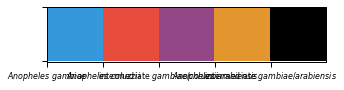

In [77]:
#countries
countries = list(all_meta.country.unique())
#long species labels
sp_nm = ['$Anopheles$ $gambiae$', '$Anopheles$ $coluzzii$',  'intermediate $gambiae$/$coluzzii$','$Anopheles$ $arabiensis$', 'intermediate $gambiae$/$arabiensis$']
#palette
flat = ["#3498db", "#e74c3c", "#944786", "#e2962d", "#000000"]
palette = sns.color_palette(flat, n_colors=len(sp_nm))
# add a colour for other_resistant
sns.palplot(palette)
plt.gca().set_xticklabels(sp_nm);

In [78]:
#build df with lat lon offsets and country labels - two letter codes?
offset_df = pd.DataFrame(index=countries, columns=["offset_lon", "offset_lat"], data=0.0)

In [79]:
offset_df.loc['Angola'] = 0, 1
offset_df.loc['Burkina Faso'] = 2, 0
offset_df.loc['Cameroon'] = -0.3, 1
offset_df.loc['Central African Republic'] = 0.3, 1
offset_df.loc["Cote d'Ivoire"] = -0.5, 0
offset_df.loc['Democratic Republic of Congo'] = 0, 3
offset_df.loc['Bioko'] = -3, -1.5
offset_df.loc['The Gambia'] = -4, 1
offset_df.loc['Ghana'] = 0.4, -1.5
offset_df.loc['Guinea-Bissau'] = -2.5, -3
offset_df.loc['Kenya'] = 0, 1
offset_df.loc['Malawi'] = -1, 0
offset_df.loc['Mali'] = 0, -1
offset_df.loc['Mayotte'] = -1, 3
offset_df.loc['Mozambique'] = 1, -2
offset_df.loc['Tanzania'] = 0, 1
offset_df.loc['Uganda'] = 0, 1

In [80]:
alternate_names = {
#     "Equatorial Guinea": "Bioko",
#     "Gambia, The": "The Gambia",
    "Central African Republic": "Central African Republic".replace(" ", "\n"),
    "Democratic Republic of Congo": "Democratic\nRepublic\nof Congo",
    "Mayotte":"Mayotte island".replace(" ", "\n"),
    "Bioko": "Bioko island".replace(" ", "\n"),
    "Cote d'Ivoire": "Cote d'Ivoire".replace(" ", "\n"),
    "The Gambia": "The Gambia".replace(" ", "\n")
}

In [81]:
label_locations = {
    c: "bottom" for c in ['Ghana', 'Guinea-Bissau', 'Gabon', 'Bioko', 'Kenya', 'Angola', 'Tanzania', 'Malawi', 'Mozambique', 'Burkina Faso', 'Democratic Republic of Congo', "Cote d'Ivoire"]}
label_locations

{'Ghana': 'bottom',
 'Guinea-Bissau': 'bottom',
 'Gabon': 'bottom',
 'Bioko': 'bottom',
 'Kenya': 'bottom',
 'Angola': 'bottom',
 'Tanzania': 'bottom',
 'Malawi': 'bottom',
 'Mozambique': 'bottom',
 'Burkina Faso': 'bottom',
 'Democratic Republic of Congo': 'bottom',
 "Cote d'Ivoire": 'bottom'}

In [82]:
arab_call = pd.crosstab(all_meta.country, all_meta.species_gambcolu_arabiensis)
colu_call = pd.crosstab(all_meta.country, all_meta.species_gambiae_coluzzii)
colu_call.rename({"intermediate": "gambaie/coluzzii"}, axis=1, inplace=True)

In [83]:
summary_counts = pd.concat([arab_call, colu_call], axis=1, sort=False).fillna(0).astype(int)
summary_counts.drop("gamb_colu", axis=1, inplace=True)

In [84]:
summary_counts.head()

,arabiensis,intermediate,coluzzii,gambiae,gambaie/coluzzii
Angola,0,0,81,0,0
Bioko,0,0,0,10,0
Burkina Faso,3,0,135,157,1
Cameroon,2,0,26,416,0
Central African Republic,0,0,18,55,0


In [85]:
ar, it, cl, ga, gc = summary_counts.loc["Uganda"]
ar, it, cl, ga, gc

(82, 1, 0, 207, 0)

In [86]:
#code to get a single averaged lat/lon and species composition for each country
def plot_pyr_map(dpi=150, extent=[-23, 48, -20, 17.5], figsize=(8, 4), label_fontsize=7):
    
    subplot_kw = dict(projection=ccrs.PlateCarree())
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=subplot_kw, dpi=dpi)
    ax.add_feature(cfeature.LAND, linewidth=1, zorder=1)
    ax.coastlines(resolution='50m', linewidth=0.7, zorder=2)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, zorder=5)
    
    for c in countries:
        
        ar, it, cl, gm, gc = summary_counts.loc[c]
        
        #use centroids for countries +- offsets
        offset_lon = offset_df.loc[c].offset_lon
        offset_lat = offset_df.loc[c].offset_lat
        
        lon = df_centroids.loc[c].longitude
        lat = df_centroids.loc[c].latitude

        centre = (lon + offset_lon, lat + offset_lat)
        radius = np.sqrt(summary_counts.loc[c].sum() * .02)
        text_offset = (radius + (0.1 * radius))
        
        ax.add_patch(plt.Circle(xy=centre, radius=radius, facecolor='none', edgecolor='k', zorder=8, lw=1))
        ax.pie([gm, cl, gc, ar, it], wedgeprops=dict(zorder=7), colors=palette, center=centre, radius=radius, shadow=True)
        
        # assume we want label above the pie unless otherwise specified
        # if we want the text to appear _below_ the pie- we need to:
        # substract radius etc (text_offset)
        # set the text vertical alignment to "top"
        
        # otherwise... 
        # the vertical offset should be positive
        # the va should be "bottom"
        
        text_pos = label_locations.get(c, "top")
        text_va = "bottom"
        
        # text_va is therefore bottom if top, and top if bottom.
        if text_pos == "bottom":
            text_va = "top"
            text_offset = -text_offset
        
        long_label = alternate_names.get(c, c)
        
        ax.text(
            centre[0], 
            centre[1] + text_offset, 
            long_label, 
            ha='center', 
            va=text_va,
            fontsize=6, 
            fontweight='bold', 
            bbox=dict(edgecolor='w', facecolor='w', pad=1, alpha=.8, ), 
            zorder=6)
        
        # plot a line if there is an offset
        if offset_lat != 0 or offset_lon != 0:
            ax.plot([lon, lon + offset_lon],[lat, lat + offset_lat], 'k-', lw=1, zorder=5)
            
        
   # manual colour legend
    plt.text(-14.0, -1.3, 'Species', fontsize=7,fontweight='bold')
    
    plt.plot([-17.5, -20.6],[-3.9, -3.9], color=flat[0], lw=7, zorder=20, solid_capstyle='round')
    plt.text(-15.5,-4.5,  sp_nm[0], fontsize=7 )

    plt.plot([-17.5, -20.6],[-6.4, -6.4], color=flat[1], lw=7, zorder=20, solid_capstyle='round')
    plt.text(-15.5,-7, sp_nm[1], fontsize=7 )
    
    plt.plot([-17.5, -20.6],[-9.0, -9.0], color=flat[2], lw=7, zorder=20, solid_capstyle='round')
    plt.text(-15.5,-9.55, sp_nm[2], fontsize=7 )
    
    plt.plot([-17.5, -20.6],[-11.6, -11.6], color=flat[3], lw=7, zorder=20, solid_capstyle='round')
    plt.text(-15.5,-12.1, sp_nm[3], fontsize=7 )
    
    plt.text(-17,-16.5, '   Sample size', fontsize=7,fontweight='bold')
    #cover tiny islands
    plt.plot([-17, -15],[-6.5, -6.5], 'w', lw=20, zorder=3)
    plt.plot([-6.5, -6],[-15, -15], 'w', lw=20, zorder=3)      

    #X0,X1,Y0,Y1  extent format  
    ax.set_extent(extent) 
    
    #size legend
    l1 = Line2D([], [], marker = 'o', markersize=11, markerfacecolor='k',  color='w') 
    l2 = Line2D([], [], marker = 'o', markersize=20, markerfacecolor='k',  color='w') 
    l3 = Line2D([], [], marker = 'o', markersize=32, markerfacecolor='k',  color='w')
    labelz = ["n=50", " n=150", "   n=300"]   
    leg = ax.legend([l1, l2, l3], labelz, ncol=3, frameon=False, fontsize=7,handlelength=2.1, loc = 3,
                     borderpad = 1.6, handletextpad=0.6, bbox_to_anchor=(-0.025, 0.0))
    # If format is not set, then the output format is inferred from the extension of fname, if any, and from rcParams["savefig.format"] = 'png' otherwise.
    #fig.savefig('../content/artwork/collection_map.svg', dpi=dpi, bbox_inches='tight');
    return ax

/opt/conda/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/opt/conda/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)


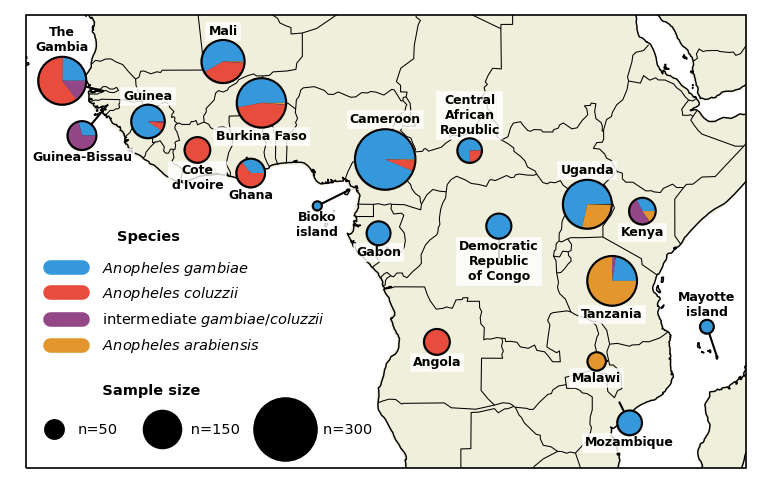

In [87]:
a = plot_pyr_map()

In [162]:
#sites dictionary
site_dict = {'Western' : ['Mali', 'Burkina Faso', "Cote d'Ivoire", 'Ghana', 'Guinea', 'Guinea-Bissau', 'The Gambia']
            , 'Central' : ['Central African Republic', 'Democratic Republic of Congo', 'Cameroon', 'Bioko', 'Gabon', 'Angola']
            , 'Eastern' : ['Uganda', 'Kenya', 'Tanzania', 'Malawi', 'Mozambique', 'Mayotte']}

In [199]:
#counts by sites
df_site_counts = all_meta.groupby(['latitude', 'longitude', 'country']).size().reset_index(name='counts')
df_site_counts.sort_values('counts')

,latitude,longitude,country,counts
61,7.902,13.607,Cameroon,1
93,10.342,14.236,Cameroon,1
39,5.484,10.593,Cameroon,1
82,9.703,13.859,Cameroon,1
47,6.097,11.141,Cameroon,1
...,...,...,...,...
34,4.341,13.558,Cameroon,110
103,11.233,-4.472,Burkina Faso,128
13,-1.962,31.651,Tanzania,170
122,13.567,-14.917,The Gambia,174


In [231]:
df_site_counts[df_site_counts.country == 'Mayotte']

,latitude,longitude,country,counts
2,-12.991,45.156,Mayotte,7
3,-12.857,45.155,Mayotte,2
4,-12.852,45.104,Mayotte,3
5,-12.797,45.122,Mayotte,3
6,-12.779,45.143,Mayotte,6
7,-12.738,45.142,Mayotte,1
8,-12.703,45.081,Mayotte,1


In [214]:
#our >= 20 sites 
df_20 = df_site_counts[df_site_counts.counts >= 10]
len(df_20),len(df_20.latitude.unique()),len(df_20.longitude.unique())

(42, 42, 41)

In [215]:
#new full meta but only containing 20 sites (to preserve all species columns)
all_20_meta = all_meta.merge(df_20[['longitude','latitude']])
len(all_20_meta.latitude.unique()),len(all_20_meta.longitude.unique())

(42, 41)

In [216]:
#summary species counts for >20 sites
arab_call = pd.crosstab(all_20_meta.latitude, all_20_meta.species_gambcolu_arabiensis)
colu_call = pd.crosstab(all_20_meta.latitude, all_20_meta.species_gambiae_coluzzii)
colu_call.rename({"intermediate": "gambiae/coluzzii"}, axis=1, inplace=True)
summary_20_counts = pd.concat([arab_call, colu_call], axis=1, sort=False).fillna(0).astype(int)
summary_20_counts.drop("gamb_colu", axis=1, inplace=True)
summary_20_counts.head()

,arabiensis,intermediate,coluzzii,gambiae,gambiae/coluzzii
latitude,,,,,
-23.716,0,0,0,74,0
-15.933,41,0,0,0,0
-8.884,0,0,81,0,0
-4.940,1,0,0,36,6
-3.511,13,0,0,28,45


In [203]:
#test
ar, it, cl, ga, gc = summary_20_counts.loc[-15.900]
ar, it, cl, ga, gc

(0, 0, 6, 67, 12)

In [204]:
#get the centroids for the countries we sample in - use this for country labels?
df_p3_centroids = df_centroids[df_centroids.index.isin(countries)].reset_index()
df_p3_centroids.head()

,name_long,pop_est,gdp_md_est,lastcensus,longitude,latitude
0,Angola,12799293,110300.0,1970,17.537368,-12.293361
1,Burkina Faso,15746232,17820.0,2006,-1.754566,12.269538
2,Bioko,334463,NaN,2015,8.749618,3.616311
3,Central African Republic,4511488,3198.0,2003,20.468268,6.568233
4,Cote d'Ivoire,20617068,33850.0,1998,-5.569216,7.628426


In [225]:
def plot_pyr_map_panel(dpi=150, extent=[-23, 48, -20, 17.5], figsize=(8, 4), label_fontsize=7, region='Western', fn=None):
    
    subplot_kw = dict(projection=ccrs.PlateCarree())
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=subplot_kw, dpi=dpi)
    ax.add_feature(cfeature.LAND, linewidth=1, zorder=1)
    ax.coastlines(resolution='50m', linewidth=0.7, zorder=2)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, zorder=5)
    
    df_region_site_counts = df_site_counts[df_site_counts['country'].isin(site_dict[region])]
    
    for _, row in df_region_site_counts.iterrows():
        lon = row['longitude']
        lat = row['latitude']
        size = row['counts']

        centre = (lon, lat)
        
        if size < 10:
            ax.add_patch(plt.Circle(xy=centre, radius=0.2, facecolor='k', edgecolor='k', zorder=4, lw=1))
        if size >= 10:
            ar, it, cl, gm, gc = summary_20_counts.loc[lat]
            ax.add_patch(plt.Circle(xy=centre, radius=0.7, facecolor='r', edgecolor='k', zorder=4, lw=1.5))
            ax.pie([gm, cl, gc, ar, it], wedgeprops=dict(zorder=7), colors=palette, center=centre, radius=0.7, shadow=True)

    #country labels
    df_region_centroids = df_p3_centroids[df_p3_centroids['name_long'].isin(site_dict[region])]
    for _, row in df_region_centroids.iterrows():
        lon = row['longitude']
        lat = row['latitude']
        plt.text(lon, lat, row.name_long, fontsize=7,fontweight='bold')
        
    ax.set_extent(extent) 
    ax.set_title(region)
    if fn:
        fig.savefig(fn, dpi=dpi, bbox_inches='tight');
    return ax

### to do?
- to build the site pie I think we could make a "summary_counts" df just for the >=20 sites.
- to pull info from this it might be easier to give each >=20 sites a code/index and link with a dict OR in this case is either lon/lat unique (less secure)?

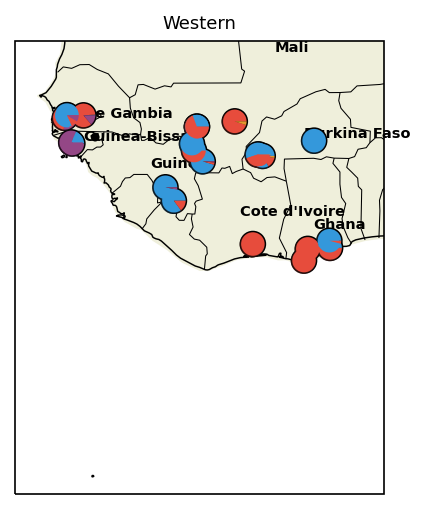

In [226]:
b = plot_pyr_map_panel(extent=[-19, 3, -9, 18], region='Western', fn='../content/images/western_map.svg')

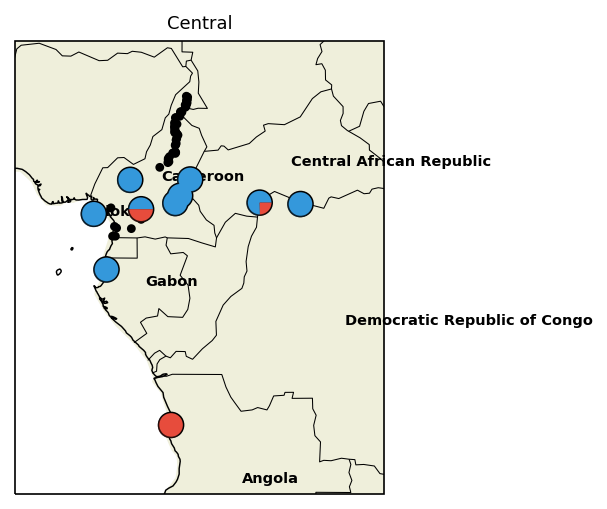

In [227]:
c = plot_pyr_map_panel(extent=[4, 26, -13, 14],region='Central')

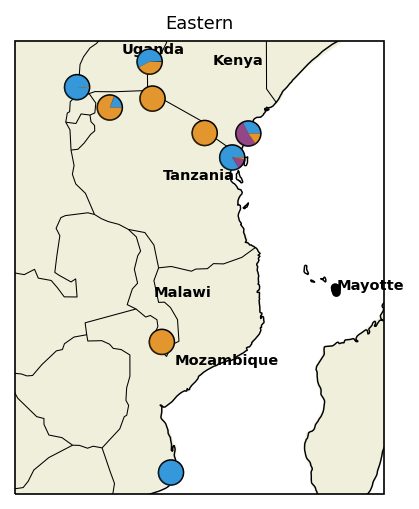

In [228]:
d = plot_pyr_map_panel(extent=[26, 48, -25, 2], region='Eastern')

# to do
- give mayotte a pie
- look at scaling pies
- <10 dot colour - tried grey centre but then that makes me want to fix the overplotting more
- if sites are so close that they overlap (this is a different distance for small/large sites) then move them so they don't and add arrows
- legends in lower WESTERN plot - <20, >=20, species colour
- final job is position of country names (or country codes) - currently placed with centroids - fix island names
- clean up code e.g. extent can be baked in - call by region